# Solving using Monte Carlo with Exploring Starts

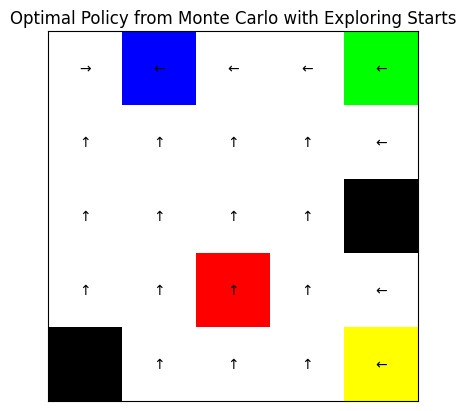

Value Function Grid:
           0          1          2          3          4
0  21.266971  19.956918  21.264983  19.849957  18.262030
1  19.862438  21.217978  19.818103  18.566063  17.337724
2  18.471243  19.786525  18.488944  17.258453   0.000000
3  17.163017  18.442927  17.182999  16.299346  15.228466
4   0.000000  17.082787  16.239787  15.280803  14.208922


In [50]:
# Monte Carlo With Exploring Starts From textbook. Implementation of that

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

# Parameters
gamma = 0.95  # discount factor
actions = ['up', 'down', 'left', 'right']
n_actions = len(actions)

# Grid dimensions
nrows, ncols = 5, 5

# Initialize the value function
Q = np.zeros((nrows, ncols, n_actions))
returns_sum = np.zeros((nrows, ncols, n_actions))
returns_count = np.zeros((nrows, ncols, n_actions))

# Special states
special_states = {
    (0, 1): {'reward': 5, 'transitions': [(3, 2)]},  # Blue square
    (0, 4): {'reward': 2.5, 'transitions': [(4, 4), (3, 2)]},  # Green square
    (3, 2): {'reward': 0},  # Red square
    (4, 4): {'reward': 0},  # Yellow square
}
terminal_states = [(4, 0), (2, 4)]  # Black squares

# Define the possible movements
movements = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}

def get_next_state(row, col, action):
    move = movements[action]
    next_row = row + move[0]
    next_col = col + move[1]

    # If the agent moves off the grid, it stays in the same state
    if next_row < 0 or next_row >= nrows or next_col < 0 or next_col >= ncols:
        return row, col, -0.2  # off-grid penalty

    # Check if the next state is terminal
    if (next_row, next_col) in terminal_states:
        return next_row, next_col, 0

    # Check if the next state is a special state
    if (next_row, next_col) in special_states:
        special = special_states[(next_row, next_col)]
        if 'transitions' in special:
            next_state = random.choice(special['transitions'])
            return next_state[0], next_state[1], special['reward']
        return next_row, next_col, special['reward']

    return next_row, next_col, -0.2

def epsilon_greedy_policy(Q, state, epsilon=0.1):
    row, col = state
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    else:
        best_action = np.argmax(Q[row, col])
        return actions[best_action]

def monte_carlo_exploring_starts(episodes=5000):
    for episode in range(episodes):
        # Initialize state and action randomly for exploring starts
        start_state = (np.random.randint(nrows), np.random.randint(ncols))
        start_action = np.random.choice(actions)
        
        # Generate an episode
        episode = []
        state = start_state
        action = start_action
        while state not in terminal_states:
            next_row, next_col, reward = get_next_state(state[0], state[1], action)
            episode.append((state, action, reward))
            if (next_row, next_col) in terminal_states:
                break
            state = (next_row, next_col)
            action = epsilon_greedy_policy(Q, state, epsilon=0.1)

        # Calculate returns and update Q
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if not any(x[0] == state and x[1] == action for x in episode[0:t]):
                action_index = actions.index(action)
                returns_sum[state[0], state[1], action_index] += G
                returns_count[state[0], state[1], action_index] += 1
                Q[state[0], state[1], action_index] = returns_sum[state[0], state[1], action_index] / returns_count[state[0], state[1], action_index]

def extract_policy(Q):
    policy = np.full((nrows, ncols), None)
    for row in range(nrows):
        for col in range(ncols):
            if (row, col) not in terminal_states and (row, col) not in special_states:
                best_action = np.argmax(Q[row, col])
                policy[row, col] = actions[best_action]
    return policy

def plot_policy(values, title):
    policy = np.zeros_like(values, dtype='<U2')
    n, m = values.shape
    for i in range(n):
        for j in range(m):
            best_action = None
            best_value = -np.inf
            directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
            for d, (di, dj) in directions.items():
                ni, nj = i + di, j + dj
                if 0 <= ni < n and 0 <= nj < m:
                    if values[ni, nj] > best_value:
                        best_value = values[ni, nj]
                        best_action = d
            if best_action:
                policy[i, j] = best_action.replace('U', '↑').replace('D', '↓').replace('L', '←').replace('R', '→')

    plt.imshow(np.ones_like(values), cmap='gray', alpha=0.3)
    colors = np.ones((n, m, 3))  # Set default color to white
    colors[0, 1] = [0, 0, 1]  # Blue for (0, 1)
    colors[0, 4] = [0, 1, 0]  # Green for (0, 4)
    colors[3, 2] = [1, 0, 0]  # Red for (3, 2)
    colors[4, 4] = [1, 1, 0]  # Yellow for (4, 4)
    colors[4, 0] = [0, 0, 0]  # Black for (4, 0)
    colors[2, 4] = [0, 0, 0]  # Black for (2, 4)
    
    plt.imshow(colors, alpha=1)

    for i in range(n):
        for j in range(m):
            color = 'black'
            plt.text(j, i, policy[i, j], ha='center', va='center', color=color)
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Run Monte Carlo with Exploring Starts
monte_carlo_exploring_starts()

# Extract the policy
policy = extract_policy(Q)

# Plot the policy
plot_policy(Q.max(axis=2), "Optimal Policy from Monte Carlo with Exploring Starts")

# Print the value function
value_function = Q.max(axis=2)
df = pd.DataFrame(value_function)
print("Value Function Grid:")
print(df)

# Solving using On-policy First-Visit MC Control for epsilon soft policy without Exploring Starts

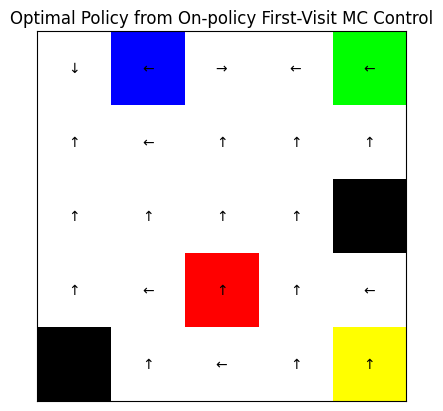

In [51]:
# Monte Carlo Without Exploring Starts From textbook

import numpy as np
import matplotlib.pyplot as plt
import random

# Parameters
gamma = 0.95  # discount factor
epsilon = 0.1  # epsilon for epsilon-soft policy
actions = ['up', 'down', 'left', 'right']
n_actions = len(actions)

# Grid dimensions
nrows, ncols = 5, 5

# Initialize the value function
Q = np.zeros((nrows, ncols, n_actions))
returns_sum = np.zeros((nrows, ncols, n_actions))
returns_count = np.zeros((nrows, ncols, n_actions))
policy = np.ones((nrows, ncols, n_actions)) * (epsilon / n_actions)
for i in range(nrows):
    for j in range(ncols):
        policy[i, j] /= np.sum(policy[i, j])  # Normalize policy probabilities

# Special states
special_states = {
    (0, 1): {'reward': 5, 'transitions': [(3, 2)]},  # Blue square
    (0, 4): {'reward': 2.5, 'transitions': [(4, 4), (3, 2)]},  # Green square
    (3, 2): {'reward': 0},  # Red square
    (4, 4): {'reward': 0},  # Yellow square
}
terminal_states = [(4, 0), (2, 4)]  # Black squares

# Define the possible movements
movements = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}

def get_next_state(row, col, action):
    move = movements[action]
    next_row = row + move[0]
    next_col = col + move[1]

    # If the agent moves off the grid, it stays in the same state
    if next_row < 0 or next_row >= nrows or next_col < 0 or next_col >= ncols:
        return row, col, -0.2  # off-grid penalty

    # Check if the next state is terminal
    if (next_row, next_col) in terminal_states:
        return next_row, next_col, 0

    # Check if the next state is a special state
    if (next_row, next_col) in special_states:
        special = special_states[(next_row, next_col)]
        if 'transitions' in special:
            next_state = random.choice(special['transitions'])
            return next_state[0], next_state[1], special['reward']
        return next_row, next_col, special['reward']

    return next_row, next_col, -0.2

def generate_episode(policy):
    episode = []
    state = (np.random.randint(nrows), np.random.randint(ncols))
    while state in terminal_states:
        state = (np.random.randint(nrows), np.random.randint(ncols))
    while True:
        action = np.random.choice(actions, p=policy[state[0], state[1]])
        next_row, next_col, reward = get_next_state(state[0], state[1], action)
        episode.append((state, action, reward))
        state = (next_row, next_col)
        if state in terminal_states:
            break
    return episode

def update_policy(Q, state, epsilon):
    row, col = state
    best_action = np.argmax(Q[row, col])
    for a in range(n_actions):
        if a == best_action:
            policy[row, col, a] = 1 - epsilon + (epsilon / n_actions)
        else:
            policy[row, col, a] = epsilon / n_actions
    policy[row, col] /= np.sum(policy[row, col])  # Ensure probabilities sum to 1

def monte_carlo_on_policy(episodes=5000):
    for episode_num in range(episodes):
        episode = generate_episode(policy)
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                action_index = actions.index(action)
                returns_sum[state[0], state[1], action_index] += G
                returns_count[state[0], state[1], action_index] += 1
                Q[state[0], state[1], action_index] = returns_sum[state[0], state[1], action_index] / returns_count[state[0], state[1], action_index]
                update_policy(Q, state, epsilon)

def extract_policy(Q):
    policy = np.full((nrows, ncols), None)
    for row in range(nrows):
        for col in range(ncols):
            if (row, col) not in terminal_states and (row, col) not in special_states:
                best_action = np.argmax(Q[row, col])
                policy[row, col] = actions[best_action]
    return policy

def plot_policy(values, title):
    policy = np.zeros_like(values, dtype='<U2')
    n, m = values.shape
    for i in range(n):
        for j in range(m):
            best_action = None
            best_value = -np.inf
            directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
            for d, (di, dj) in directions.items():
                ni, nj = i + di, j + dj
                if 0 <= ni < n and 0 <= nj < m:
                    if values[ni, nj] > best_value:
                        best_value = values[ni, nj]
                        best_action = d
            if best_action:
                policy[i, j] = best_action.replace('U', '↑').replace('D', '↓').replace('L', '←').replace('R', '→')

    plt.imshow(np.ones_like(values), cmap='gray', alpha=0.3)
    colors = np.ones((n, m, 3))  # Set default color to white
    colors[0, 1] = [0, 0, 1]  # Blue for (0, 1)
    colors[0, 4] = [0, 1, 0]  # Green for (0, 4)
    colors[3, 2] = [1, 0, 0]  # Red for (3, 2)
    colors[4, 4] = [1, 1, 0]  # Yellow for (4, 4)
    colors[4, 0] = [0, 0, 0]  # Black for (4, 0)
    colors[2, 4] = [0, 0, 0]  # Black for (2, 4)
    
    plt.imshow(colors, alpha=1)

    for i in range(n):
        for j in range(m):
            color = 'black'
            plt.text(j, i, policy[i, j], ha='center', va='center', color=color)
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Run Monte Carlo with On-policy control
monte_carlo_on_policy()

# Extract the policy
policy = extract_policy(Q)

# Plot the policy
plot_policy(Q.max(axis=2), "Optimal Policy from On-policy First-Visit MC Control")

# # Print the value function
# value_function = Q.max(axis=2)
# df = pd.DataFrame(value_function)
# print("Value Function Grid:")
# print(df)

# Off-policy Predicition via Importance Sampling

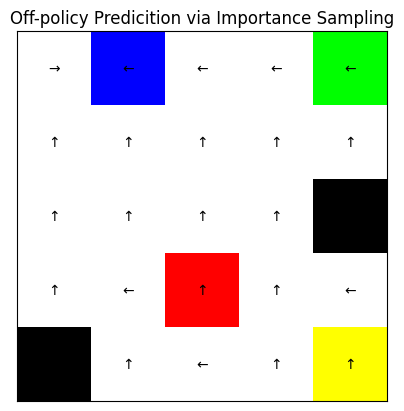

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the gridworld environment
class GridWorld:
    def __init__(self):
        self.grid_size = 5
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.actions = ['up', 'down', 'left', 'right']
        self.action_prob = 1 / len(self.actions)
        self.terminal_states = [(4, 0), (2, 4)]
        self.special_states = {
            (0, 1): ('jump', 5, (3, 2)),
            (0, 4): ('prob_jump', 2.5, (4, 4), (3, 2)),
        }
        
    def step(self, state, action):
        if state in self.terminal_states:
            return state, 0, True
        
        if state in self.special_states:
            spec = self.special_states[state]
            if spec[0] == 'jump':
                return spec[2], spec[1], False
            elif spec[0] == 'prob_jump':
                next_state = spec[2] if np.random.rand() < 0.5 else spec[3]
                return next_state, spec[1], False
        
        x, y = state
        if action == 'up' and x > 0:
            x -= 1
        elif action == 'down' and x < self.grid_size - 1:
            x += 1
        elif action == 'left' and y > 0:
            y -= 1
        elif action == 'right' and y < self.grid_size - 1:
            y += 1
        
        next_state = (x, y)
        reward = -0.2 if next_state not in self.terminal_states else 0
        return next_state, reward, next_state in self.terminal_states

# Off-policy prediction using importance sampling
def off_policy_prediction(env, num_episodes, target_policy, behavior_policy):
    value_estimates = np.zeros((env.grid_size, env.grid_size))
    returns = {state: [] for state in np.ndindex(env.grid_size, env.grid_size)}
    
    for episode in range(num_episodes):
        state = (np.random.randint(env.grid_size), np.random.randint(env.grid_size))
        episode_states = []
        episode_rewards = []
        episode_actions = []
        
        while True:
            action = np.random.choice(env.actions, p=[behavior_policy[action] for action in env.actions])
            next_state, reward, done = env.step(state, action)
            episode_states.append(state)
            episode_rewards.append(reward)
            episode_actions.append(action)
            if done:
                break
            state = next_state
        
        G = 0
        W = 1
        for t in reversed(range(len(episode_states))):
            state = episode_states[t]
            action = episode_actions[t]
            G = G + episode_rewards[t]
            returns[state].append(G)
            value_estimates[state] = np.mean(returns[state])
            W = W * target_policy[state][action] / behavior_policy[action]
            if W == 0:
                break
    
    return value_estimates

def plot_policy(values, title):
    policy = np.zeros_like(values, dtype='<U2')
    n, m = values.shape
    for i in range(n):
        for j in range(m):
            if (i, j) in [(4, 0), (2, 4)]:
                policy[i, j] = ''
                continue
            best_action = None
            best_value = -np.inf
            directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
            for d, (di, dj) in directions.items():
                ni, nj = i + di, j + dj
                if 0 <= ni < n and 0 <= nj < m and (ni, nj) not in [(4, 0), (2, 4)]:
                    if values[ni, nj] > best_value:
                        best_value = values[ni, nj]
                        best_action = d
            if best_action:
                policy[i, j] = best_action.replace('U', '↑').replace('D', '↓').replace('L', '←').replace('R', '→')

    plt.imshow(np.ones_like(values), cmap='gray', alpha=0.3)
    colors = np.ones((n, m, 3))  # Set default color to white
    colors[0, 1] = [0, 0, 1]  # Blue for (0, 1)
    colors[0, 4] = [0, 1, 0]  # Green for (0, 4)
    colors[3, 2] = [1, 0, 0]  # Red for (3, 2)
    colors[4, 4] = [1, 1, 0]  # Yellow for (4, 4)
    colors[4, 0] = [0, 0, 0]  # Black for (4, 0)
    colors[2, 4] = [0, 0, 0]  # Black for (2, 4)
    
    plt.imshow(colors, alpha=1)

    for i in range(n):
        for j in range(m):
            color = 'black'
            plt.text(j, i, policy[i, j], ha='center', va='center', color=color)
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Define target and behavior policies
target_policy = {state: {action: 0.25 for action in ['up', 'down', 'left', 'right']} for state in np.ndindex(5, 5)}
behavior_policy = {action: 0.25 for action in ['up', 'down', 'left', 'right']}

# Initialize environment
env = GridWorld()

# Perform off-policy prediction
value_estimates = off_policy_prediction(env, num_episodes=1000, target_policy=target_policy, behavior_policy=behavior_policy)

# Plot the state value estimates
# plt.figure(figsize=(10, 8))
# sns.heatmap(value_estimates, annot=True, fmt=".1f", cmap="coolwarm")
# plt.title("State Value Estimates")
# plt.xlabel("Grid X")
# plt.ylabel("Grid Y")
# plt.show()

# Plot the policy
plot_policy(value_estimates, "Off-policy Predicition via Importance Sampling")

# Permutation of locations of green and blue squares and using policy iteration, evaluation and improvment

In [ ]:
# WARNING: CONVERGENCE MAY A LONG TIME

import numpy as np
import matplotlib.pyplot as plt
import random

# Parameters
gamma = 0.95  # discount factor
theta = 1e-6  # small threshold for convergence
actions = ['up', 'down', 'left', 'right']
action_prob = 0.25  # probability for each action

# Grid dimensions
nrows, ncols = 5, 5

# Initialize the policy and value function
policy = np.random.choice(actions, size=(nrows, ncols))
V = np.zeros((nrows, ncols))

# Special states
blue = (0, 0)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)
terminal_states = [(1, 0), (3, 4)]  # Black squares

# Define the possible movements
movements = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}

def permute_blue_green(blue, green):
    if np.random.rand() < 0.1:
        return green, blue
    return blue, green

def get_next_state(row, col, action, blue, green):
    move = movements[action]
    next_row = row + move[0]
    next_col = col + move[1]

    # If the agent moves off the grid, it stays in the same state
    if next_row < 0 or next_row >= nrows or next_col < 0 or next_col >= ncols:
        return row, col, -0.2  # off-grid penalty

    # Check if the next state is terminal
    if (next_row, next_col) in terminal_states:
        return next_row, next_col, 0

    # Check if the next state is a special state
    if (next_row, next_col) == blue:
        return red[0], red[1], 5
    if (next_row, next_col) == green:
        next_state = random.choice([yellow, red])
        return next_state[0], next_state[1], 2.5

    return next_row, next_col, -0.2

def policy_evaluation(policy, V, blue, green):
    while True:
        delta = 0
        new_V = np.copy(V)
        for row in range(nrows):
            for col in range(ncols):
                if (row, col) not in terminal_states:
                    action = policy[row, col]
                    next_row, next_col, reward = get_next_state(row, col, action, blue, green)
                    new_V[row, col] = reward + gamma * V[next_row, next_col]
                else:
                    new_V[row, col] = 0
                delta = max(delta, np.abs(new_V[row, col] - V[row, col]))
        V = new_V
        if delta < theta:
            break
    return V

def policy_improvement(policy, V, blue, green):
    policy_stable = True
    for row in range(nrows):
        for col in range(ncols):
            old_action = policy[row, col]
            action_values = []
            for action in actions:
                next_row, next_col, reward = get_next_state(row, col, action, blue, green)
                action_values.append(reward + gamma * V[next_row, next_col])
            best_action = actions[np.argmax(action_values)]
            policy[row, col] = best_action
            if old_action != best_action:
                policy_stable = False
    return policy, policy_stable

def policy_iteration():
    global blue, green, policy, V
    policy_stable = False
    while not policy_stable:
        blue, green = permute_blue_green(blue, green)
        V = policy_evaluation(policy, V, blue, green)
        policy, policy_stable = policy_improvement(policy, V, blue, green)
    return policy, V

def plot_policy(policy, title):
    fig, ax = plt.subplots()
    for row in range(nrows):
        for col in range(ncols):
            if policy[row, col] is not None:
                ax.text(col, row, action_symbols[policy[row, col]], va='center', ha='center')
            if (row, col) in terminal_states:
                ax.add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, fill=True, color='black'))
            if (row, col) == blue:
                ax.add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, fill=True, color='blue'))
            if (row, col) == green:
                ax.add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, fill=True, color='green'))
            if (row, col) == red:
                ax.add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, fill=True, color='red'))
            if (row, col) == yellow:
                ax.add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, fill=True, color='yellow'))
    ax.set_xticks(np.arange(ncols))
    ax.set_yticks(np.arange(nrows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.grid(True)
    plt.title(title)
    plt.show()

# Define action symbols for visualization
action_symbols = {
    'up': '↑',
    'down': '↓',
    'left': '←',
    'right': '→',
}

# Initialize policy and value function globally
policy = np.random.choice(actions, size=(nrows, ncols))
V = np.zeros((nrows, ncols))

# Run policy iteration
optimal_policy, optimal_value = policy_iteration()

# Plot the optimal policy
plot_policy(optimal_policy, "Optimal Policy with Permutation of Blue and Green Squares")